No solution has been found for the given maximum number of iterations.


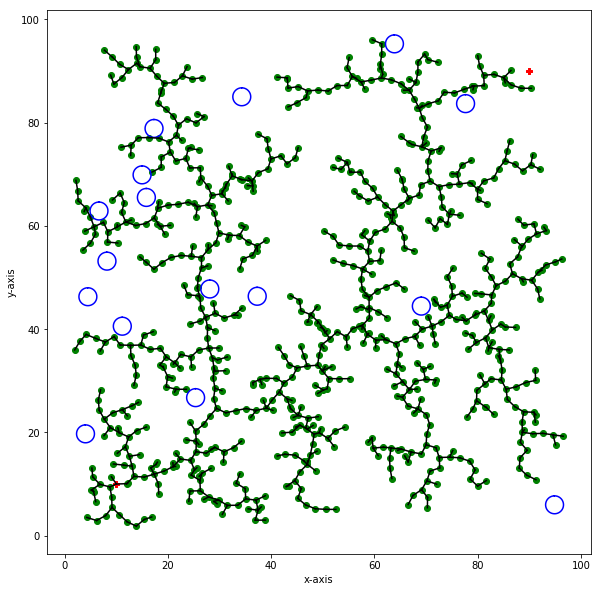

 Total time for RRT:  1 is:  4.4446306228637695
No solution has been found for the given maximum number of iterations.


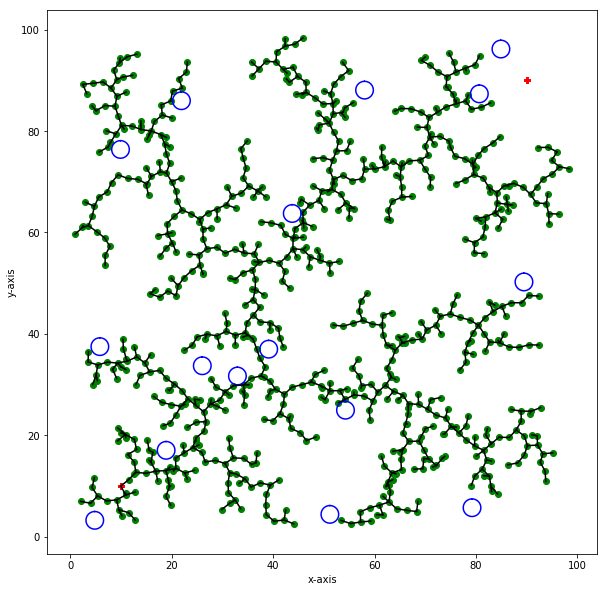

 Total time for RRT:  2 is:  4.438363552093506


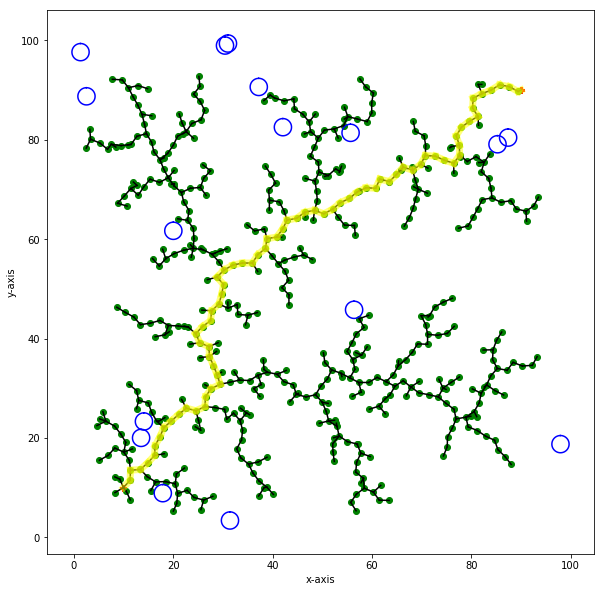

 Total time for RRT:  3 is:  3.098233699798584


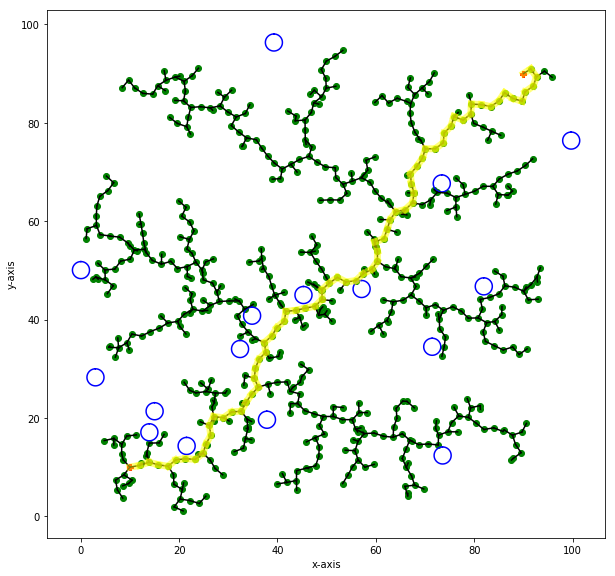

 Total time for RRT:  4 is:  3.636484146118164


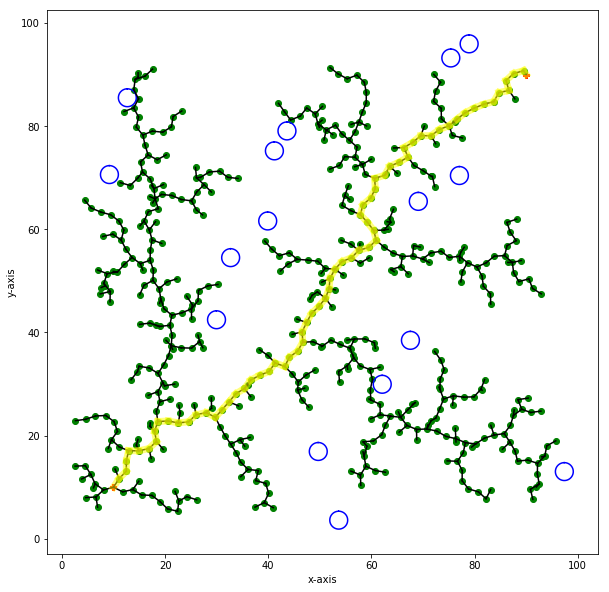

 Total time for RRT:  5 is:  3.0166704654693604


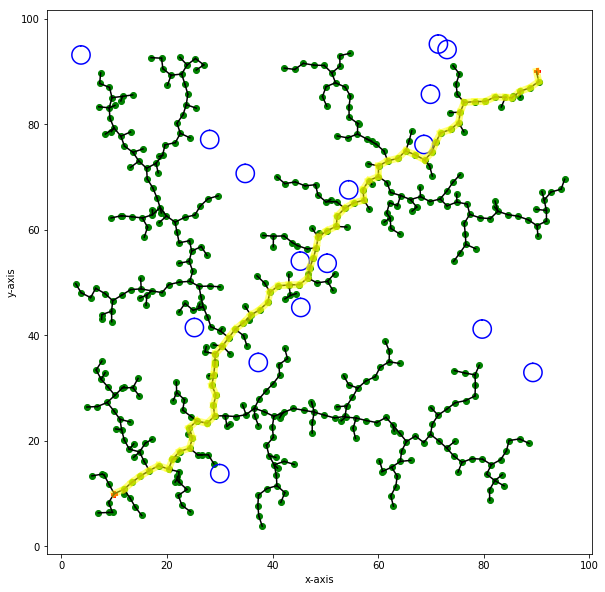

 Total time for RRT:  6 is:  2.5720276832580566
No solution has been found for the given maximum number of iterations.


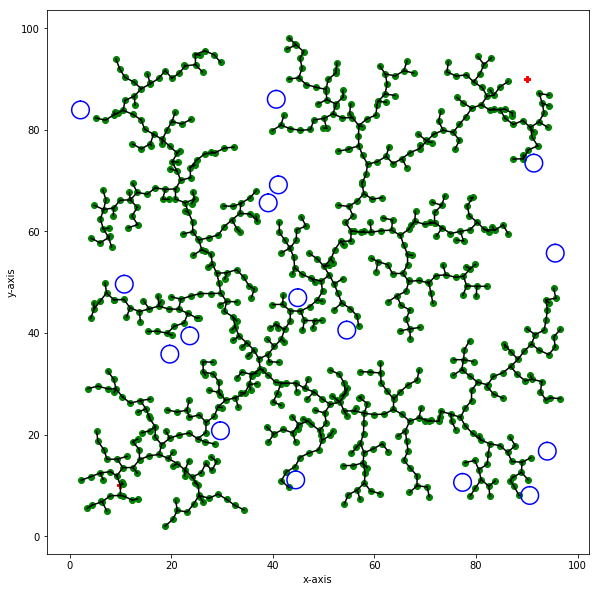

 Total time for RRT:  7 is:  4.289444923400879


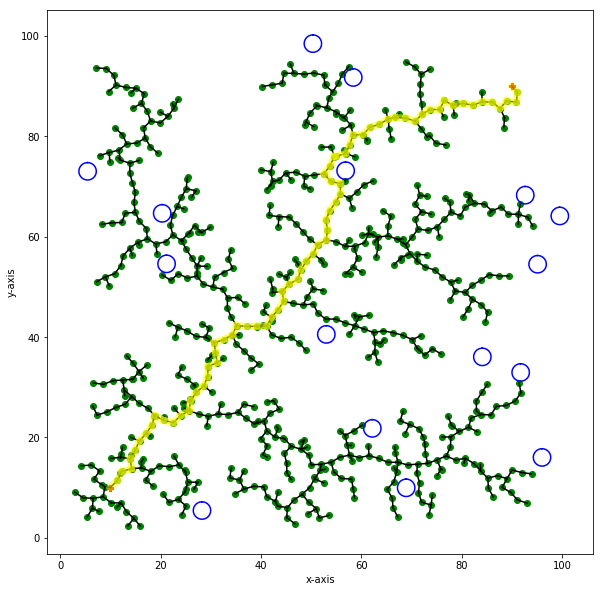

 Total time for RRT:  8 is:  4.041844844818115


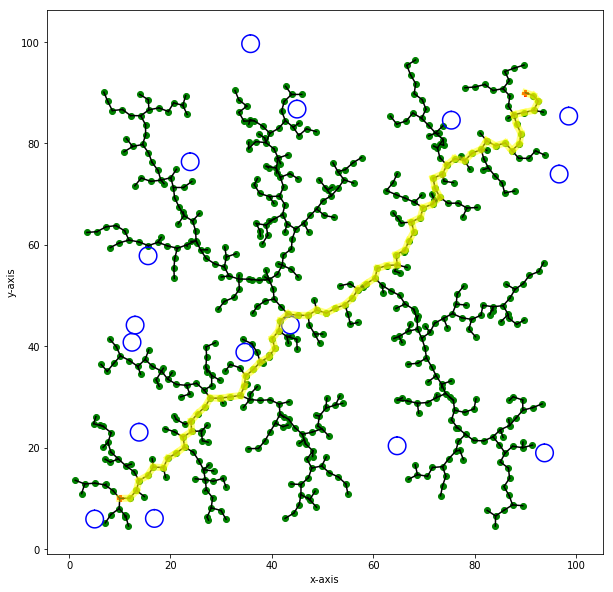

 Total time for RRT:  9 is:  3.3500494956970215


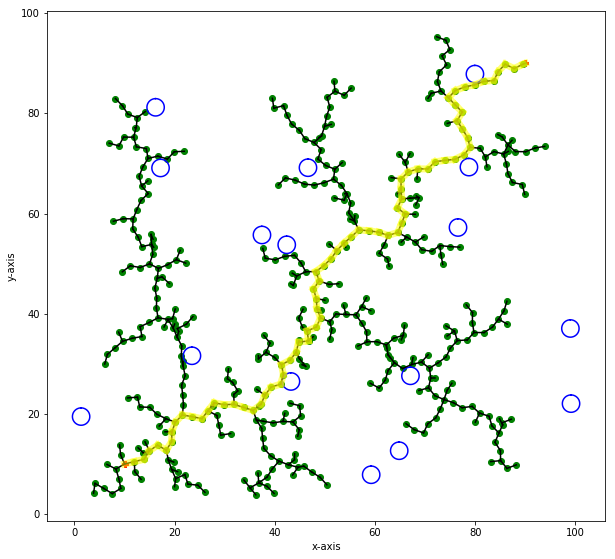

 Total time for RRT:  10 is:  2.4078307151794434


'\n@cuda.jit\ndef kernel_para_RRT(d_diff):\n    i= cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x\n    if i < d_diff.shape[0]:\n        d_diff[i] = 1\n        #main()\n\nstart = cuda.event()\nstop = cuda.event() \nevents = 10\nstreams = []\nfor i in range(events):\n    n = np.ones(10)\n    num = 10\n    #d_f = cuda.to_device(n)\n    d_diff = cuda.device_array_like(n)\n    streams.append(cuda.stream)\n    start.record()\n    blocks, threads = (num+TPB-1)//TPB, TPB\n    kernel_para_RRT[blocks, threads](d_diff)\n    main()\n    stop.record()\n    tot_time = cuda.event_elapsed_time(start, stop)\n    print(" Time taken for RRT: ", i, "is: ", tot_time,"ms")\n    #synchronize()\n'

In [4]:
import math
import numpy as np
from numba import cuda
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline

TPB = 256 # number of threads in a block

# device function_NN
@cuda.jit(device=True)
def euc_distance_2d_device(x1,y1,x2,y2):
    d = math.sqrt((x2-x1)**2+(y2-y1)**2)
    return d

@cuda.jit()
def distanceKernel(d_out,x,y,d_V,nov):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    if i < nov:
        d_out[i] = euc_distance_2d_device(x,y,d_V[0,i],d_V[1,i])

# wrapper function_NN
def dArray(x,y,V,nov):
    d_V = cuda.to_device(V) # copies the input data to a device array on the GPU
    d_distance = cuda.device_array(nov) # creates an empty array to hold the output
    BPG = (nov + TPB - 1)//TPB # computes number of blocks
    distanceKernel[BPG,TPB](d_distance,x,y,d_V,nov)
    return d_distance.copy_to_host()

# kernel for CC
@cuda.jit()
def ccKernel(d_out,x,y,d_O,all_radii):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    #flag = 1
    if i < all_radii.size:# and flag ==1:
        d_out[i] = euc_distance_2d_device(x,y,d_O[0,i],d_O[1,i])>all_radii[i] # should be 1 for no collision
        # flag = d_out[i]

# wrapper function_CC
def dArray_CC(x,y,obs_coors,allowable_radii):
    noo = allowable_radii.size
    d_all_radii = cuda.to_device(allowable_radii) # copies the input data to a device array on the GPU
    d_O = cuda.to_device(obs_coors) # copies the input data to a device array on the GPU
    d_collision = cuda.device_array(noo) # creates an empty array to hold the output
    BPG = (noo + TPB - 1)//TPB # computes number of blocks
    ccKernel[BPG,TPB](d_collision,x,y,d_O,d_all_radii)
    return d_collision.copy_to_host()

def euc_distance_2d(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

def nearest_neighbor_2d_parallel(x,y,V,nov):
    distance = dArray(x,y,V,nov)
    ind_min = np.argmin(distance)
    min_dis = distance[ind_min]
    return [min_dis,ind_min]

def collision_check_parallel(x,y,obstacle_coordinates,obstacle_radii):
    allowable_radii = obstacle_radii*2/np.sqrt(3)
    flag = 0 # means no collision
    if all(dArray_CC(x,y,obstacle_coordinates,allowable_radii)):
        flag = 1
    return flag

def draw_circle(xc,yc,r):
    t = np.arange(0,2*np.pi,.05)
    x = xc+r*np.sin(t)
    y = yc+r*np.cos(t)
    plt.plot(x,y,c='blue')

def main():
    max_iter = 800
    epsilon = 2 # step size

    flag = 0 # for finding a connectivity path

    # initial and goal points/states
    x0 = 10
    y0 = 10
    x_goal = 90
    y_goal = 90
    plt.figure(figsize=[10,10])
    plt.scatter([x0,x_goal],[y0,y_goal],c='r',marker="P")

    # obstacle info
    noo = 16 # no. of obstacles
    radius = np.sqrt(3)/2*epsilon
    obs_radii = radius*np.ones(noo)
    obs_coors = 100*np.random.rand(2,noo) # position of obstacles
    for i in range(0,noo):
        draw_circle(obs_coors[0,i],obs_coors[1,i],obs_radii[i])

    if euc_distance_2d(x0,y0,x_goal,y_goal)<epsilon:
        flag = 1
        plt.plot([x0,x_goal],[y0,y_goal],c='black')
    else:
        vertices = np.zeros([2,max_iter+1])
        A = -np.ones([max_iter+1,max_iter+1])
        vertices[0,0] = x0
        vertices[1,0] = y0
        A[0,0] = 0

    nov = 0 # no. of vertices except the initial one
    i = 0
    while flag==0 and i<max_iter:
        i += 1
        x_rand= 100*np.random.rand(1)
        y_rand= 100*np.random.rand(1)
        xy_rand = np.array([x_rand,y_rand]).reshape(2,)
        [min_dis,p_near] = nearest_neighbor_2d_parallel(x_rand[0],y_rand[0],vertices,nov+1)
        if min_dis<epsilon:
            x_new = x_rand
            y_new = y_rand
        else: # interpolate
            r = epsilon/min_dis # ratio
            x_new = vertices[0,p_near]+r*(x_rand-vertices[0,p_near])
            y_new = vertices[1,p_near]+r*(y_rand-vertices[1,p_near])
        if collision_check_parallel(x_new[0],y_new[0],obs_coors,obs_radii):
            nov = nov+1
            vertices[0,nov] = x_new
            vertices[1,nov] = y_new
            plt.scatter(x_new,y_new,c='g')
            plt.plot([vertices[0,p_near],x_new],[vertices[1,p_near],y_new],c='black')
            A[nov,:] = A[p_near,:]
            A[nov,nov] = nov
            if euc_distance_2d(x_new,y_new,x_goal,y_goal)<epsilon:
                nov = nov+1
                A[nov,:] = A[nov-1,:]
                A[nov,nov] = nov
                vertices[0,nov] = x_goal
                vertices[1,nov] = y_goal
                plt.plot([x_new,x_goal],[y_new,y_goal],c='black')
                flag = 1
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.axis('scaled')

    if flag ==1 and nov!=0:
        B = np.zeros(nov)
        nov_path =0 # no. of vertices on the connectivity path
        for i in range(0,nov+1):
            if A[nov,i]>-1:
                B[nov_path]=A[nov,i]
                nov_path += 1
        B = B[0:nov_path]
        for i in range(0, B.size-1):
            plt.plot([vertices[0,int(B[i])],vertices[0,int(B[i+1])]],[vertices[1,int(B[i])],vertices[1,int(B[i+1])]],c='yellow',linewidth=7,alpha=0.5)
    elif flag ==0:
        flag = 0
        print('No solution has been found for the given maximum number of iterations.')
    else:
        print('The initial and goal configurations are close enough.')
        plt.plot([x0,x_goal],[y0,y_goal],c='yellow',linewidth=7,alpha=0.5)
        
        # plt.savefig('the_basic.png')
    plt.show()

for i in range(10):
    start = time.time()
    main()
    tot_time = (time.time()-start)
    print(" Total time for RRT: ", i+1, "is: ", tot_time)

"""
@cuda.jit
def kernel_para_RRT(d_diff):
    i= cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    if i < d_diff.shape[0]:
        d_diff[i] = 1
        #main()

start = cuda.event()
stop = cuda.event() 
events = 10
streams = []
for i in range(events):
    n = np.ones(10)
    num = 10
    #d_f = cuda.to_device(n)
    d_diff = cuda.device_array_like(n)
    streams.append(cuda.stream)
    start.record()
    blocks, threads = (num+TPB-1)//TPB, TPB
    kernel_para_RRT[blocks, threads](d_diff)
    main()
    stop.record()
    tot_time = cuda.event_elapsed_time(start, stop)
    print(" Time taken for RRT: ", i, "is: ", tot_time,"ms")
    #synchronize()
"""

#for s in streams:
#    s.synchronize()

#for i in events:
#    cuda.event_elapsed_time(start[i], end[i])
    #main()
